In [18]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import scipy 
from scipy.integrate import trapz,simps
import scipy.optimize as op
from colossus.cosmology import cosmology

from scipy.optimize import minimize

In [286]:
import emcee
from IPython.display import display, Math

In [287]:
#Función para histogramas y puntos
def plot_data(flat_s):
    
    n = len(flat_s.T)
    m = []
    mp = []
    titulo = ['Histograma de $\Omega_m$', 'Histograma de b','Histograma de $beta$']
    
    #Sección para graficar:
    plt.figure(figsize=(10,10))  
    for i in range(n):
        for j in range(i+1):
            k = i-j
            if i == k:
                plt.subplot(n,n,((i*n)+k+1))
                hist = plt.hist(flat_samples.T[k], bins=20,facecolor='grey',alpha = 0.8)
                #m.append(hist[1][np.where(hist[0]==np.max(hist[0]))])
                mcmc = np.percentile(flat_s[:, i], [16, 50, 84])
                m.append(mcmc[1])
                plt.axvline(m[i],color='r',label = np.round(m[i],4))
                plt.title(titulo[i],fontsize=18)
                plt.legend();
            else:
                plt.subplot(n,n,((i*n)+k+1))
                plt.hexbin(flat_samples.T[k], flat_samples.T[i], gridsize=30, cmap='Greys')
                plt.axvline(m[k],color='r',label = np.round(m[k],4))
                plt.axhline(m[i],color='b',label = np.round(m[i],4))
                plt.legend();

    plt.savefig('graficas.png')
    plt.show()
    
    return  m

In [288]:
#Modelo:
def model_pk(Om,b2,beta,k,z=0.57):
    cosmo = cosmology.setCosmology('planck15',)
    cosmo.Om0 = Om
    return (1+beta)*b2**2*cosmo.matterPowerSpectrum(k,z) #función

In [289]:
#Funcion para calcular la chi cuadrada
def chisq_pk(theta,data):
    om, b2, beta = theta
    #Nuestros datos
    x, y, yerr = data
    sigma2 = yerr**2 
    #Sumamos para encontrar el logaritmo del likelihood
    return -0.5*np.sum((y-model_pk(om,b2,beta,x,z=0.57))**2/sigma2 + np.log(sigma2))

In [290]:
# Función Prior
def log_prior(theta):
    om, b2, beta = theta
    if 0.05 < om < 1.0 and 0.05 < b2 < 5.0 and 0.001 < beta < 1.0:
        return 0.0
    return -np.inf

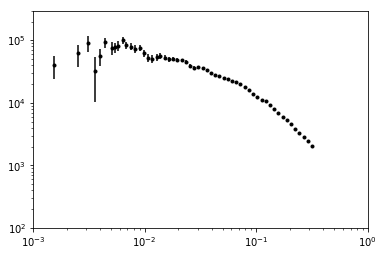

In [224]:
#Cargamos los datos:
pk_cmasdr12 = np.loadtxt('/home/echeveste/Mis_trabajos/analisis_datos/da2019-Oscar2401/Semana_12/GilMarin_boss_data/post-recon/cmass/GilMarin_2016_CMASSDR12_measurement_monopole_post_recon.txt').T

plt.figure()
plt.loglog()
plt.errorbar(k, pk, yerr=pk_err, fmt=".k", capsize=0, label="DATOS")
plt.xlim(1e-3,1)
plt.ylim(100,3e5);

(1500, 300000.0)

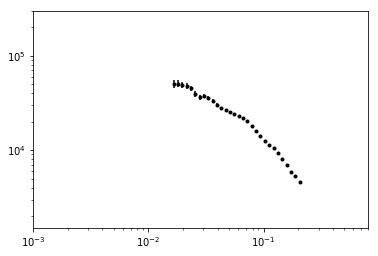

In [291]:
#Quitamos algunos datos 
li = 20
ls = len(pk_cmasdr12[0])-5
k, pk, pk_err = pk_cmasdr12[0][li:ls],pk_cmasdr12[1][li:ls],pk_cmasdr12[2][li:ls]

plt.figure()
plt.loglog()
plt.errorbar(k, pk, yerr=pk_err, fmt=".k", capsize=0, label="DATOS")
plt.xlim(1e-3,0.8)
plt.ylim(1500,3e5)

In [292]:
#Hacemos una primera aproximación de los parametros:
cosmo = cosmology.setCosmology('planck15',)

data = [k,pk,pk_err]

om, b2, beta = 0.36, 1.8, 0.001

np.random.seed(42)
nll = lambda *args: -chisq_pk(*args)
initial = np.array([om, b2, beta])
soln = minimize(nll, initial, args=(data))
om_ml, b2_ml, beta_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(om_ml))
print("b = {0:.3f}".format(b2_ml))
print("f = {0:.3f}".format(beta_ml))

Maximum likelihood estimates:
m = 0.360
b = 2.023
f = 0.100


In [293]:
k_m = 10**np.linspace(-6,5,100000)
pk_m = model_pk(om_ml, b2_ml, beta_ml,k_m,z=0.57)

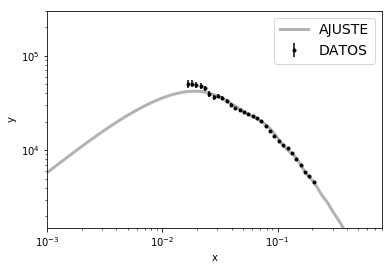

In [294]:
plt.figure()
plt.loglog()
plt.errorbar(k, pk, yerr=pk_err, fmt=".k", capsize=0, label="DATOS")
plt.plot(k_m, pk_m, "k", alpha=0.3, lw=3, label="AJUSTE")
plt.legend(fontsize=14)
plt.xlim(1e-3,0.8)
plt.ylim(1500,3e5)
plt.xlabel("x")
plt.ylabel("y");

In [295]:
#Definimos una dinción para calcular el logaritmo de la probabilidad final
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + chisq_pk(theta, [x, y, yerr])

In [245]:
pos = soln.x + 1e-4 * np.random.randn(30, 3) #nwalkers = 30, dim = 3 
nwalkers, ndim = pos.shape 

In [246]:
#implementamos la herramienta de EMCEE
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(k,pk,pk_err)) 
sampler.run_mcmc(pos, 10000, progress=True);

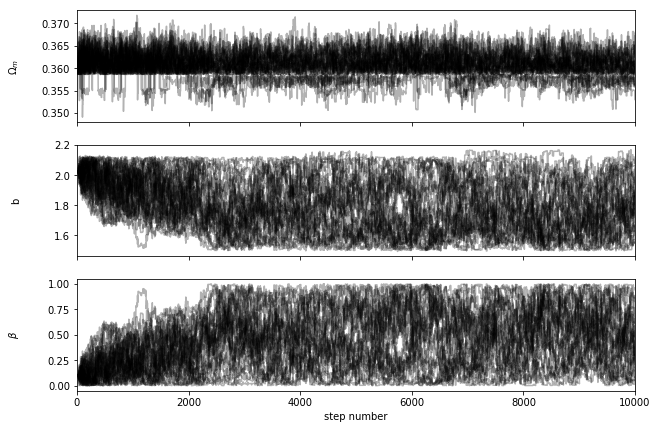

In [247]:
#Graficamos los caminadorer 
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$\Omega_m$", "b", "$\\beta$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [280]:
#Quitamos los primeros 100 pasos 
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(19800, 3)


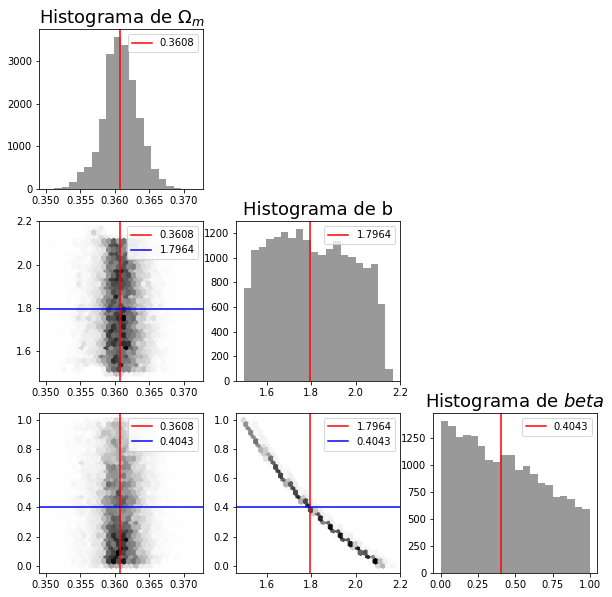

In [281]:
#Ploteamos los histogramas
m  = plot_data(flat_samples)

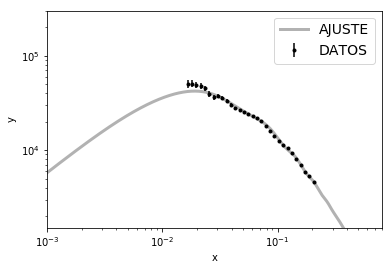

In [282]:
#Vemos el ajuste 

k_m = 10**np.linspace(-6,5,100000)
pk_m = model_pk(m[0], m[1],m[2],k_m,z=0.57)

plt.figure()
plt.loglog()
plt.errorbar(k, pk, yerr=pk_err, fmt=".k", capsize=0, label="DATOS")
plt.plot(k_m, pk_m, "k", alpha=0.3, lw=3, label="AJUSTE")
plt.legend(fontsize=14)
plt.xlim(1e-3,0.8)
plt.ylim(1500,3e5)
plt.xlabel("x")
plt.ylabel("y");

In [285]:
#Vemos los resultados con sus respectivos errores
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [283]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [313.94585972 622.1755114  631.74480032]